# Overview

This notebook implements an early evaluation of the strength of the theoretical gateway aggregator model using experimental results.
Compares single experimental setups with the Pinciroli's (2023) theoretical results to generate an intuition of their relationship.


It visualizes the results, calculates the _mean average (percentage) error_ between the results, suggesting how 'off' the results are.
It also calculates Pearson's $r$ to understand the correlation between results.


In [16]:
# Forces the notebook to always reload packages.
%reload_ext autoreload
%autoreload 2

import datetime
import json
import os
import typing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

import gssi_experiment.util.util as util
import gssi_experiment.util.prometheus_raw_data_helper as prom_raw_data_helper
import gssi_experiment.util.notebook_helper as nb_helper
import gssi_experiment.util.stat_helper as stat_helper

pincirollis_data_path = "/workspaces/muBench-experiment/gssi_experiment/pipes_and_filters/pipes_and_filters_joint/Core2_N50.csv"
synth_df = pd.read_csv(pincirollis_data_path, header=0)
synth_df.describe()

base_path = "/workspaces/muBench-experiment/gssi_experiment/pipes_and_filters/pipes_and_filters_joint/results/pinciroli_replication_2/"



intensity_key = "freemium_intensity"

## Dataframe creation

In [17]:
TIME_FORMAT = "%Y-%m-%dT%H:%M:%S.000Z"
TIMEFORMAT_2 = "%Y-%m-%d %H:%M:%S"

service_cols = ["s1", "s2", "s3", "s4"]


def is_2cpu_experiment(experiment_folder: str) -> bool:
    # HACK: this is super hacky.
    path = experiment_folder[len(base_path) :]
    chunks = path.split("/")
    exp_name = chunks[1]
    chunks = exp_name.split("_")
    exp_index = int(chunks[1])
    return exp_index % 2 == 1


def get_data_points() -> typing.Iterator:
    for experiment_folder in util.iterate_through_nested_folders(
        base_path, max_depth=2
    ):
        if not is_2cpu_experiment(experiment_folder):
            continue

        # Calculates delay data
        mubench_file = f"{experiment_folder}/mubench_results.csv"
        exp_df = pd.read_csv(mubench_file, header=0)
        avg_latency = np.average(exp_df["latency_ms"])

        # Reads metadata to calculate intensity
        meta_path = f"{experiment_folder}/metadata.json"
        with open(meta_path, "r", encoding="utf-8") as meta_file:
            metadata = json.loads(meta_file.read())
        cpu_limit = metadata["cmd_arguments"]["cpu_limit"]
        replicas = metadata["cmd_arguments"]["replicas"]
        max_steps = metadata["cmd_arguments"]["simulation_steps"]
        # HACK: add this to the metadata.
        step = int(os.path.basename(experiment_folder).split("_")[0])
        intensity = step / max_steps

        # Calculates CPU utilization data.
        start_time = datetime.datetime.strptime(metadata["start_time"], TIME_FORMAT)
        end_time = datetime.datetime.strptime(metadata["end_time"], TIME_FORMAT)
        utilization_data = prom_raw_data_helper.calculate_average_cpu_time(
            experiment_folder, service_cols, start_time, end_time
        )

        data_point = [
            step,
            max_steps,
            intensity,
            avg_latency,
            cpu_limit,
            replicas,
            metadata["start_time"],
            metadata["end_time"],
            *utilization_data,
        ]
        yield data_point


cols = [
    "step",
    "max_step",
    intensity_key,
    "avg_latency_ms",
    "cpu_limit",
    "replicas",
    "experiment_start_time",
    "experiment_end_time",
]
cpu_util_format = "cpu_utilization_{service}"
cpu_columns = [cpu_util_format.format(service=service) for service in service_cols]
cols.extend(cpu_columns)

data_points = get_data_points()

df = pd.DataFrame(data_points, columns=cols)

old_df_len = len(df)
df = df.dropna()
new_df_len = len(df)
if new_df_len != old_df_len:
    print("!!!SOME ROWS WERE REMOVED BECAUSE THEY ARE NAN!!!")
    print(f"The row count was {old_df_len} and now is {new_df_len}.")

df

Retrying to calculate averages with services: ['s1', 's2', 's3.1', 's4']


,step,max_step,freemium_intensity,avg_latency_ms,cpu_limit,replicas,experiment_start_time,experiment_end_time,cpu_utilization_s1,cpu_utilization_s2,cpu_utilization_s3,cpu_utilization_s4
0,0,5,0.0,1786.229939,1000m,1,2023-11-25T11:57:06.000Z,2023-11-25T12:07:59.000Z,0.338467,0.370796,0.002591,0.994128
1,1,5,0.2,1358.610930,1000m,1,2023-11-25T12:31:29.000Z,2023-11-25T12:42:21.000Z,0.462547,0.574930,0.255890,1.000044
2,2,5,0.4,1102.462965,1000m,1,2023-11-25T12:20:05.000Z,2023-11-25T12:30:58.000Z,0.588516,0.798770,0.601204,0.995397
3,3,5,0.6,1161.819561,1000m,1,2023-11-25T12:42:53.000Z,2023-11-25T12:53:45.000Z,0.548474,0.641154,0.976840,0.524845
4,4,5,0.8,1288.196529,1000m,1,2023-11-25T12:54:17.000Z,2023-11-25T13:05:10.000Z,0.647197,0.712579,0.979114,0.256505
5,5,5,1.0,1897.707963,1000m,1,2023-11-25T12:08:30.000Z,2023-11-25T12:19:34.000Z,0.444026,0.540093,0.983261,0.002897
6,0,5,0.0,1802.794505,1000m,1,2023-11-25T14:14:05.000Z,2023-11-25T14:24:58.000Z,0.334378,0.366677,0.002336,0.993100
7,1,5,0.2,1449.013013,1000m,1,2023-11-25T15:11:05.000Z,2023-11-25T15:21:58.000Z,0.473047,0.529895,0.249835,0.998075
8,2,5,0.4,1094.130475,1000m,1,2023-11-25T14:25:29.000Z,2023-11-25T14:36:21.000Z,0.612125,0.694676,0.629524,0.998804
9,3,5,0.6,1150.397789,1000m,1,2023-11-25T14:36:52.000Z,2023-11-25T14:47:45.000Z,0.674871,0.780989,0.971887,0.541567


In [18]:
synth_cpu_cols = ["N_A", "R0", "N_B", "Ut1", "Ut2", "Ut3_A", "Ut3_B"]

pinc_df = synth_df[synth_cpu_cols]
pinc_df.loc[:, intensity_key] = pinc_df['N_A'] / (pinc_df["N_A"] + pinc_df["N_B"])
pinc_df = pinc_df.drop("N_A", axis=1)

df = pd.merge(df, pinc_df, on=intensity_key)

df

/tmp/ipykernel_24681/3666857541.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pinc_df.loc[:, intensity_key] = pinc_df['N_A'] / (pinc_df["N_A"] + pinc_df["N_B"])


,step,max_step,freemium_intensity,avg_latency_ms,cpu_limit,replicas,experiment_start_time,experiment_end_time,cpu_utilization_s1,cpu_utilization_s2,cpu_utilization_s3,cpu_utilization_s4,R0,N_B,Ut1,Ut2,Ut3_A,Ut3_B
0,0,5,0.0,1786.229939,1000m,1,2023-11-25T11:57:06.000Z,2023-11-25T12:07:59.000Z,0.338467,0.370796,0.002591,0.994128,497.587200,50,0.398786,0.453734,0.000000,1.000000
1,0,5,0.0,1802.794505,1000m,1,2023-11-25T14:14:05.000Z,2023-11-25T14:24:58.000Z,0.334378,0.366677,0.002336,0.993100,497.587200,50,0.398786,0.453734,0.000000,1.000000
2,0,5,0.0,1812.094222,1000m,1,2023-11-25T17:16:51.000Z,2023-11-25T17:27:44.000Z,0.341838,0.372264,0.004890,0.969817,497.587200,50,0.398786,0.453734,0.000000,1.000000
3,1,5,0.2,1358.610930,1000m,1,2023-11-25T12:31:29.000Z,2023-11-25T12:42:21.000Z,0.462547,0.574930,0.255890,1.000044,325.410274,40,0.726369,0.859908,0.592485,1.000000
4,1,5,0.2,1449.013013,1000m,1,2023-11-25T15:11:05.000Z,2023-11-25T15:21:58.000Z,0.473047,0.529895,0.249835,0.998075,325.410274,40,0.726369,0.859908,0.592485,1.000000
5,1,5,0.2,1432.786142,1000m,1,2023-11-25T17:05:26.000Z,2023-11-25T17:16:20.000Z,0.479384,0.526529,0.244572,0.999879,325.410274,40,0.726369,0.859908,0.592485,1.000000
6,2,5,0.4,1102.462965,1000m,1,2023-11-25T12:20:05.000Z,2023-11-25T12:30:58.000Z,0.588516,0.798770,0.601204,0.995397,293.558123,30,0.828231,0.976653,0.778690,0.988911
7,2,5,0.4,1094.130475,1000m,1,2023-11-25T14:25:29.000Z,2023-11-25T14:36:21.000Z,0.612125,0.694676,0.629524,0.998804,293.558123,30,0.828231,0.976653,0.778690,0.988911
8,2,5,0.4,1082.439217,1000m,1,2023-11-25T16:42:37.000Z,2023-11-25T16:53:31.000Z,0.687952,0.683126,0.614312,0.993354,293.558123,30,0.828231,0.976653,0.778690,0.988911
9,3,5,0.6,1161.819561,1000m,1,2023-11-25T12:42:53.000Z,2023-11-25T12:53:45.000Z,0.548474,0.641154,0.976840,0.524845,306.354252,20,0.816053,0.988448,0.925397,0.804359


# Request Delay


## Visualization


averaged_columns=['avg_latency_ms', 'R0', 'N_A', 'R0', 'N_B', 'Ut1', 'Ut2', 'Ut3_A', 'Ut3_B', 'cpu_utilization_s1', 'cpu_utilization_s2', 'cpu_utilization_s3', 'cpu_utilization_s4']


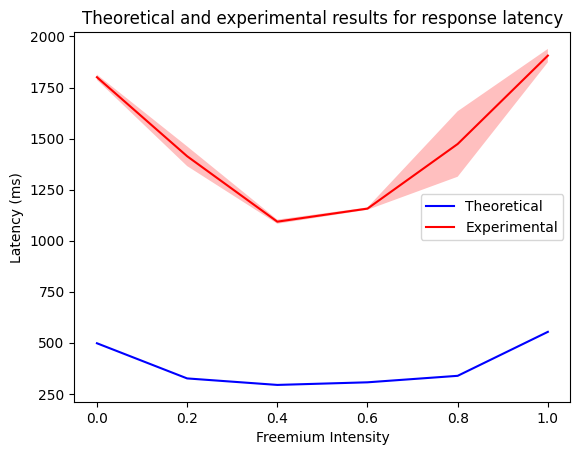

In [19]:
group_colums = [intensity_key]
averaged_columns = ["avg_latency_ms", "R0", *synth_cpu_cols, *cpu_columns]
avg_df = nb_helper.to_averaged_df(df, group_colums, averaged_columns)

nb_helper.create_figure(avg_df, intensity_key, "R0", "avg_latency_ms")

averaged_columns=['avg_latency_ms', 'R0', 'N_A', 'R0', 'N_B', 'Ut1', 'Ut2', 'Ut3_A', 'Ut3_B', 'cpu_utilization_s1', 'cpu_utilization_s2', 'cpu_utilization_s3', 'cpu_utilization_s4']


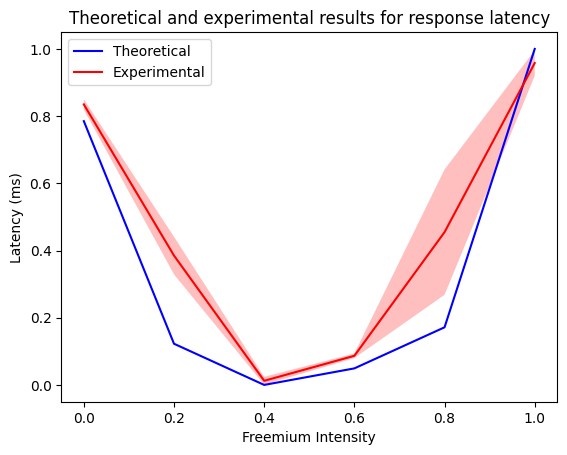

In [20]:
# Normalized data


def normalize(x, x_min, x_max):
    x -= x_min
    x /= x_max - x_min
    return x


df_norm = pd.DataFrame()
df_norm[intensity_key] = df[intensity_key]

r0_min, r0_max = min(df["R0"]), max(df["R0"])
df_norm["R0"] = df["R0"].transform(lambda x: normalize(x, r0_min, r0_max))

lat_min, lat_max = min(df["avg_latency_ms"]), max(df["avg_latency_ms"])
df_norm["avg_latency_ms"] = df["avg_latency_ms"].transform(
    lambda x: normalize(x, lat_min, lat_max)
)


avg_norm_df = nb_helper.to_averaged_df(df_norm, group_colums, averaged_columns)
nb_helper.create_figure(avg_norm_df, intensity_key, "R0", "avg_latency_ms")

## Evaluation


### Compares the delay data set using MAPE and Spearman's r


In [21]:
correlation_coefficient, p_value = spearmanr(df["R0"], df["avg_latency_ms"])

# Display the result
print("Spearman's correlation coefficient:")
sig = "significant" if p_value < 0.05 else "insignificant"
print(f"avg_latency_ms: {correlation_coefficient=:.3f} ({p_value=:.3f} ({sig}))")

Spearman's correlation coefficient:
avg_latency_ms: correlation_coefficient=0.969 (p_value=0.000 (significant))


### Mean average percentage error

Intuitively, how off the result is on average.

$\displaystyle M = \frac{1}{n}\sum^n_{t=1} \bigg|\frac{A_t - F_t}{A_t}\bigg|$

Where $n$ is the number of elements, $F_t$ the forecast value, and $A_t$ the actual value.


In [22]:

absolute_mape = stat_helper.mape(df["R0"], df["avg_latency_ms"])
eps = 1
normalized_mape = stat_helper.mape(df_norm["R0"] + eps, df_norm["avg_latency_ms"] + eps)

print(f"{absolute_mape=:.2f}, {normalized_mape=:.2f}% ({eps=})")

absolute_mape=73.97, normalized_mape=7.81% (eps=1)


### Mean absolute error

$\displaystyle M = \frac{1}{n}\sum^n_{t=1}\bigg|A_t - F_t\bigg|$

Where $n$ is the number of elements, $F_t$ the forecast value, and $A_t$ the actual value.


In [23]:
def mae(expected, real) -> float:
    m = 0
    for real_ele, expected_ele in zip(expected, real):
        m += abs((real_ele - expected_ele))
    m /= len(expected)
    return m


absolute_mae = mae(df["R0"], df["avg_latency_ms"])
normalized_mae = 100 * mae(df_norm["R0"], df_norm["avg_latency_ms"])

print(f"{absolute_mae=:.3f}, {normalized_mae=:.2f}%")

absolute_mae=1088.160, normalized_mae=11.45%


# Visualizing the relationship

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


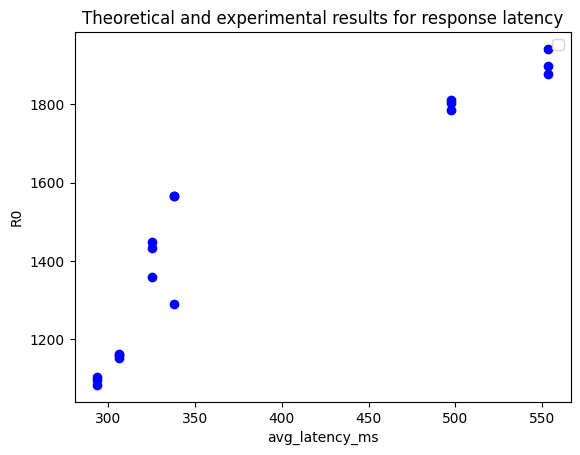

In [24]:
# Create a figure and axis
plt.figure()
ax = plt.axes()

# Plot the first line (sine function)
ax.scatter(df["R0"], df["avg_latency_ms"], color="blue")

# Add labels and a legend
ax.set_ylabel("R0")
ax.set_xlabel("avg_latency_ms")
ax.set_title("Theoretical and experimental results for response latency")
ax.legend()

# Show the plot
plt.show()

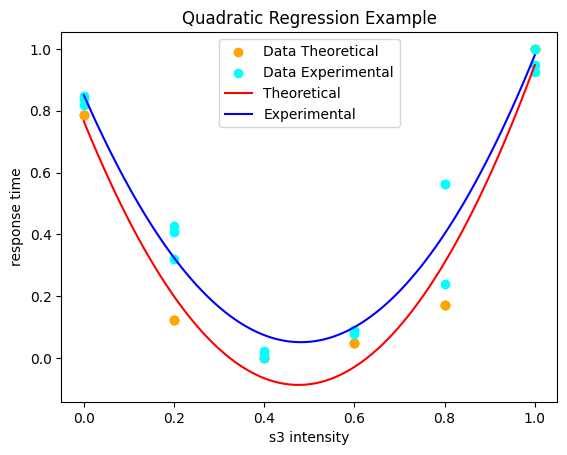

In [25]:
import numpy as np
import matplotlib.pyplot as plt


def normalize_field(df: pd.DataFrame, field: str) -> pd.DataFrame:
    min_x, max_x = min(df[field]), max(df[field])
    df.loc[:, field] = df[field].transform(lambda x: normalize(x, min_x, max_x))
    return df

test_df = df.copy()
test_df = normalize_field(test_df, "R0")
test_df = normalize_field(test_df, "avg_latency_ms")

test_df


def make_model(x, y):
    # Fit a quadratic regression model
    coefficients = np.polyfit(x, y, 2)
    quadratic_model = np.poly1d(coefficients)

    # Generate y values from the model for smooth plotting
    x_smooth = np.linspace(min(x), max(x), 100)
    y_smooth = quadratic_model(x_smooth)
    return x_smooth, y_smooth


# Sample data
# x = np.array([1, 2, 3, 4, 5])
# y = np.array([3, 8, 12, 8, 3])
x = test_df[intensity_key].tolist()
y = test_df["R0"].tolist()
x_smooth, y_smooth = make_model(x, y)

y2 = test_df["avg_latency_ms"].tolist()
x2_smooth, y2_smooth = make_model(x, y2)

# Plot the data and the quadratic regression curve
plt.scatter(x, y, label='Data Theoretical', color='orange')
plt.scatter(x, y2, label='Data Experimental', color='cyan')
plt.plot(x_smooth, y_smooth, color="red", label="Theoretical")
plt.plot(x2_smooth, y2_smooth, color="blue", label="Experimental")
plt.xlabel('s3 intensity')
plt.ylabel("response time")
plt.title("Quadratic Regression Example")
plt.legend()
plt.show()

# CPU Utilization

## Visualization

averaged_columns=['avg_latency_ms', 'R0', 'N_A', 'R0', 'N_B', 'Ut1', 'Ut2', 'Ut3_A', 'Ut3_B', 'cpu_utilization_s1', 'cpu_utilization_s2', 'cpu_utilization_s3', 'cpu_utilization_s4']


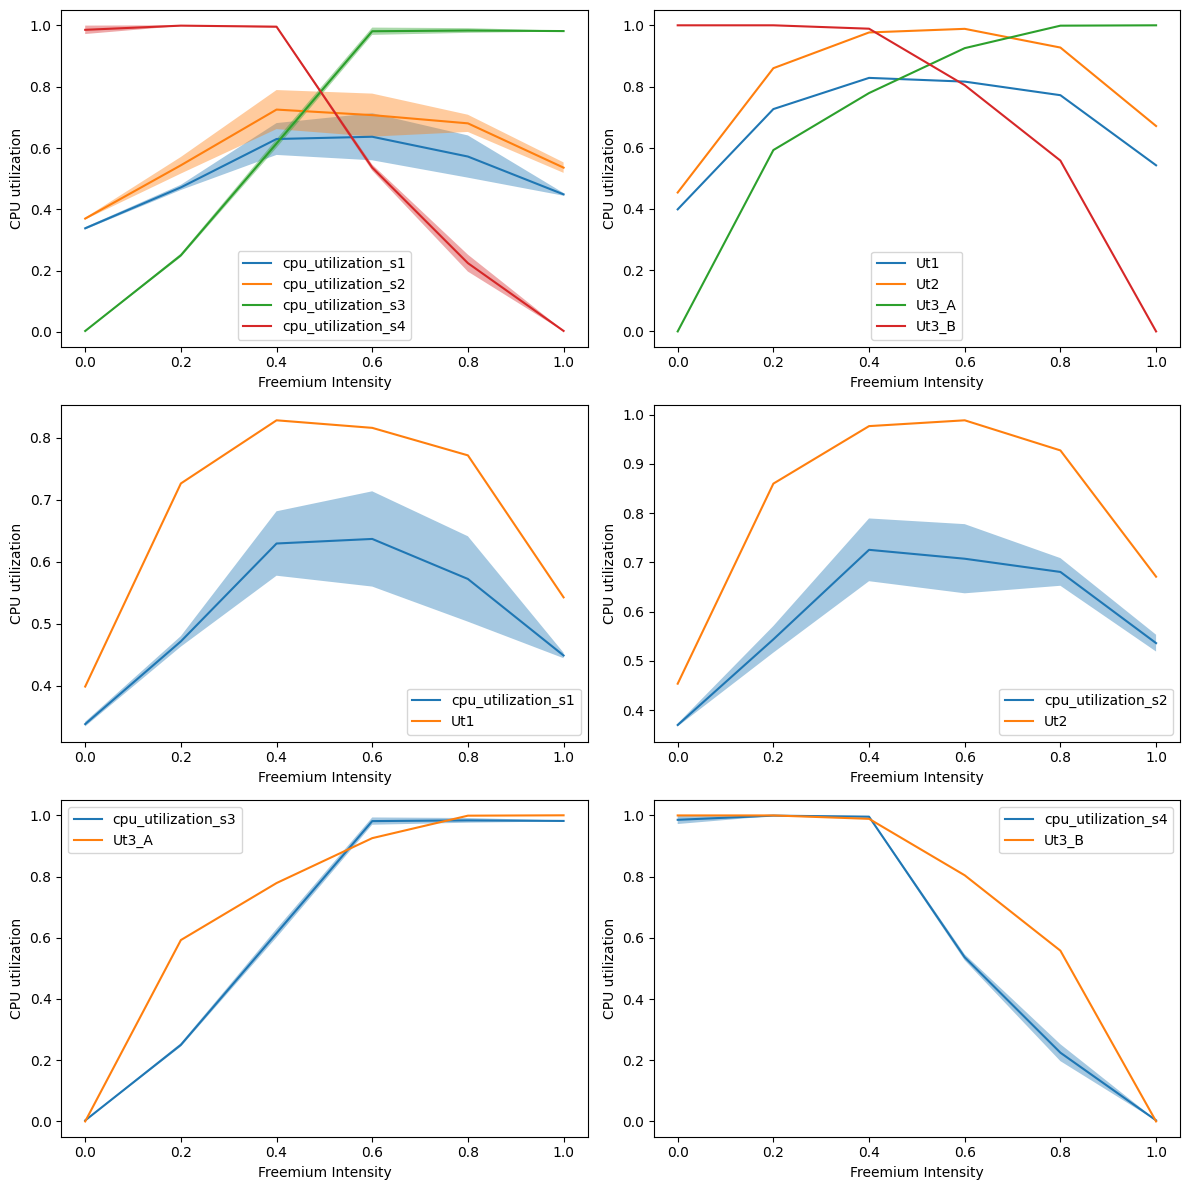

In [26]:
comparison_tuples = [
    (
        "cpu_utilization_s1",
        "cpu_utilization_s2",
        "cpu_utilization_s3",
        "cpu_utilization_s4",
    ),
    ("Ut1", "Ut2", "Ut3_A", "Ut3_B"),
    ("cpu_utilization_s1", "Ut1"),
    ("cpu_utilization_s2", "Ut2"),
    ("cpu_utilization_s3", "Ut3_A"),
    ("cpu_utilization_s4", "Ut3_B"),
]
avg_df = nb_helper.to_averaged_df(df, group_colums, averaged_columns)
nb_helper.create_plot_comparisons(comparison_tuples, avg_df, intensity_key)

averaged_columns=['avg_latency_ms', 'R0', 'N_A', 'R0', 'N_B', 'Ut1', 'Ut2', 'Ut3_A', 'Ut3_B', 'cpu_utilization_s1', 'cpu_utilization_s2', 'cpu_utilization_s3', 'cpu_utilization_s4']


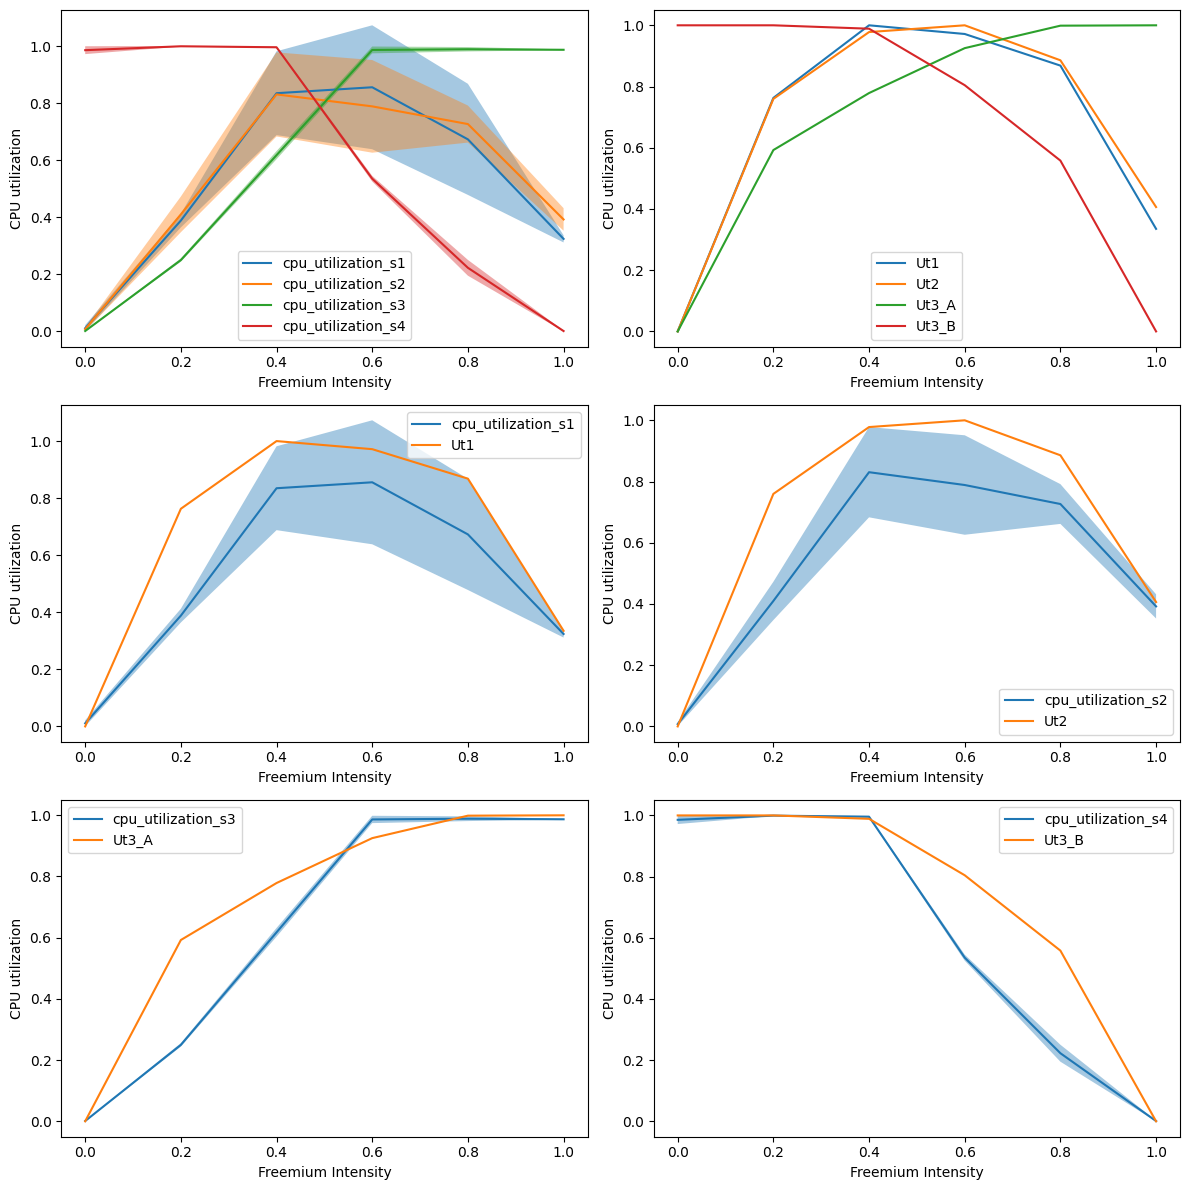

In [27]:
norm_df = pd.DataFrame()

for col in df.select_dtypes(include="number").columns:
    min_x, max_x = min(df[col]), max(df[col])
    norm_df[col] = df[col].transform(lambda x: normalize(x, min_x, max_x))

comparison_tuples = [
    (
        "cpu_utilization_s1",
        "cpu_utilization_s2",
        "cpu_utilization_s3",
        "cpu_utilization_s4",
    ),
    ("Ut1", "Ut2", "Ut3_A", "Ut3_B"),
    ("cpu_utilization_s1", "Ut1"),
    ("cpu_utilization_s2", "Ut2"),
    ("cpu_utilization_s3", "Ut3_A"),
    ("cpu_utilization_s4", "Ut3_B"),
]
avg_norm_df = nb_helper.to_averaged_df(norm_df, group_colums, averaged_columns)
nb_helper.create_plot_comparisons(comparison_tuples, avg_norm_df, intensity_key)

## Evaluation

In [28]:
comparison_tuples = [
    ("cpu_utilization_s1", "Ut1"),
    ("cpu_utilization_s2", "Ut2"),
    ("cpu_utilization_s3", "Ut3_A"),
    ("cpu_utilization_s4", "Ut3_B"),
]

### Spearman's correlation coefficient

In [29]:
print("Spearman's correlation coefficient:")
for real, expected in comparison_tuples:
    correlation_coefficient, p_value = spearmanr(df[expected], df[real])

    # Display the result
    sig = "significant" if p_value < 0.05 else "insignificant"
    print(f"{real}: {correlation_coefficient:.3f} ({p_value=:.3f} {sig})")

Spearman's correlation coefficient:
cpu_utilization_s1: 0.925 (p_value=0.000 significant)
cpu_utilization_s2: 0.868 (p_value=0.000 significant)
cpu_utilization_s3: 0.912 (p_value=0.000 significant)
cpu_utilization_s4: 0.887 (p_value=0.000 significant)


### Mean average (percentage) error

In [30]:
for real, expected in comparison_tuples:
    mape_score = stat_helper.mape(df[expected], df[real])
    mae_score = mae(df[expected], df[real])
    print(f"{real}: {mape_score=:.2f}%, {mae_score=:.3f}")

    eps = 1
    norm_mape_score = stat_helper.mape(norm_df[expected] + eps, norm_df[real] + eps)
    norm_mae_score = 100 * mae(norm_df[expected], norm_df[real])
    print(f"{real}: {norm_mape_score=:.2f}% ({eps=}), {norm_mae_score=:.2f}%\n")

cpu_utilization_s1: mape_score=31.76%, mae_score=0.164
cpu_utilization_s1: norm_mape_score=9.97% (eps=1), norm_mae_score=15.03%

cpu_utilization_s2: mape_score=36.43%, mae_score=0.219
cpu_utilization_s2: norm_mape_score=9.78% (eps=1), norm_mae_score=15.29%

cpu_utilization_s3: mape_score=45.46%, mae_score=0.100
cpu_utilization_s3: norm_mape_score=6.95% (eps=1), norm_mae_score=9.82%

cpu_utilization_s4: mape_score=50.51%, mae_score=0.104
cpu_utilization_s4: norm_mape_score=7.70% (eps=1), norm_mae_score=10.46%

